## 电力窃漏电用户自动识别

### 1、背景与挖掘目标

#### 1.1  背景

    1.传统的防窃漏电方法主要通过定期巡检、定期校验电表、用户举报窃电等方法来发现窃电或计量装置故障。

　　2. 但这种方法对人的依赖性太强，抓窃查漏的目标不明确。。

　　3. 通过采集电量异常、负荷异常、终端报警、主站报警、线损异常等信息，建立数据分析模型，来实时监测窃漏电情况和发现计量装置的故障。

#### 1.2 目标

　　1. 归纳出窃漏电用户的关键特征，构建窃漏电用户的识别模型。

　　2. 利用实时检测数据，调用窃漏电用户识别模型实现实时诊断。

### 2、分析方法与过程

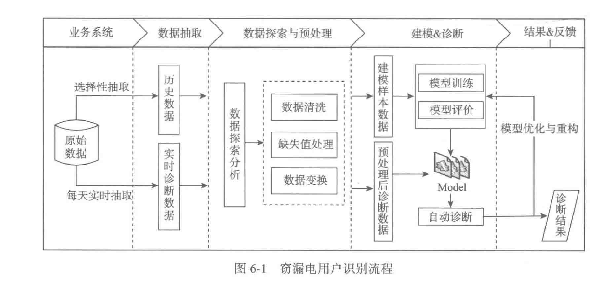

In [32]:
import matplotlib.image as mping
import matplotlib.pyplot as plt 

pro=mping.imread(r'D:\Entertainment\jyputer\Jyputer\Electric leakage\用户识别流程.png')
plt.figure(figsize=(10,10))
plt.imshow(pro)
plt.axis('off')
plt.show()

### 3、数据探索

#### 3.1  数据简单描述

In [6]:
import pandas as pd
import numpy as np
inputfile='D:\Entertainment\jyputer\Jyputer\Electric leakage\missing_data.xls'
clearnedfile='D:\Entertainment\jyputer\Jyputer\Electric leakage\clearnedfile.xls'
data=pd.read_excel(inputfile,encoding='utf-8')
data.head(5)

,日期,用户1,用户2,用户3
0,2014-09-01,235.8333,324.0343,478.3231
1,2014-09-02,236.2708,325.6379,515.4564
2,2014-09-03,238.0521,328.0897,517.0909
3,2014-09-04,235.9063,NaN,514.8900
4,2014-09-05,236.7604,268.8324,NaN


三个用户19个工作日的电量数据

In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 4 columns):
日期     21 non-null datetime64[ns]
用户1    19 non-null float64
用户2    17 non-null float64
用户3    17 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 752.0 bytes
None


In [8]:
print(data.describe().T)

     count        mean        std       min       25%       50%        75%  \
用户1   19.0  236.262626   1.225465  234.4688  235.4948  235.9063  237.19275   
用户2   17.0  363.666265  57.600529  206.4349  328.0897  388.0230  401.62340   
用户3   17.0  553.901624  67.707729  435.3508  514.8900  538.3470  611.34080   

          max  
用户1  238.6563  
用户2  416.8795  
用户3  660.2347  


In [12]:
data.isnull().sum() # 查看每一列缺失值的个数

日期     0
用户1    2
用户2    4
用户3    4
dtype: int64

用户的用电数据中存在缺失值

#### 3.2  数据缺失值填充（拉格朗日插值法）

In [24]:
from scipy.interpolate import lagrange #导入拉格朗日插值函数

# 自定义列向量插值函数
# s为列向量，n为被插值的位置，k为取前后的数据个数，默认为5
def ployinterp_column(s,n,k=5):
    y=s[list(range(n-k,n))+list(range(n+1,n+1+k))]  # 取数
    y=y[y.notnull()]#剔除空值
    return lagrange(y.index,list(y))(n)#插值并返回插值结果

# 逐个元素判断是否需要插值
for i in data.columns:
    for j in range(len(data)):
        if (data[i].isnull())[j]:#如果为空即插值
            data[i][j]=ployinterp_column(data[i],j)

data.to_excel(clearnedfile) # 输出结果
# excel的写入函数为pd.DataFrame.to_excel();必须是DataFrame写入excel中

### 4、数据变换

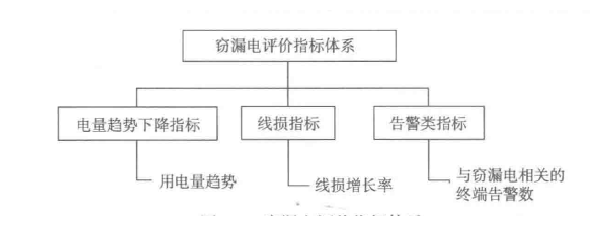

In [35]:
import matplotlib.image as mping
import matplotlib.pyplot as plt

cri=mping.imread(r'D:\Entertainment\jyputer\Jyputer\Electric leakage\窃漏电评价指标体系.png')
plt.figure(figsize=(10,10))
plt.imshow(cri)
plt.axis('off')
plt.show()

电量趋势下降指标：正常用户的用电量较为平稳，窃漏电用户的用电量呈现下降的趋势，然后趋于平缓
因此可以考虑前后几天作为统计窗口期，考虑期间的下降趋势，利用电量做直线拟合得到的斜率作为衡量
，如果斜率随时间不断下降，那该用户的窃漏电可能性就很大

线损指标：用于衡量供电线路的损失比例，同时可结合线户拓扑关系。若用户发生窃漏电，则当天
的线损率会上升，但由于用户每天的用电量存在波动，单纯以当天线损率上升了作为窃漏电特征则损失过大，
所以考虑前后几天的线损率平均值，判断其增大率是否大于1%，若线损率的增长率大于1%，则具有窃漏电的可能性

告警类指标：计算发生与窃漏电相关的终端报警的次数总和，作为告警类指标

### 5、模型构建

#### 5.1  构建窃漏电用户识别模型

##### 数据划分

In [76]:
import pandas as pd
import numpy as np
from random import shuffle #导入随机函数shuffle，用来打乱数据
data=pd.read_excel(r'D:\Entertainment\jyputer\Jyputer\Electric leakage\model.xls')
train1='D:\Entertainment\jyputer\Jyputer\Electric leakage\train.xls'
test1='D:\Entertainment\jyputer\Jyputer\Electric leakage\test.xls'

# data1=data['电量趋势下降指标','线损指标','告警类指标','是否窃漏电']
data=data.iloc[1:,2:6]# 前三列是特征，第四列是标签
data.head(4)

,电量趋势下降指标,线损指标,告警类指标,是否窃漏电
1,4,0,4,1
2,2,1,1,1
3,9,0,0,0
4,3,1,0,0


#### 交叉验证，80%的train作为训练集来训练模型；20%train作为测试集来评价模型

In [77]:
data = matrix(data)#将表格转换为矩阵

shuffle(data)#随机打乱数据

p = 0.8 #设置训练数据比例
train = data[:int(len(data)*p),:]#前80%为训练集用作训练模型
test = data[int(len(data)*p):,:]#后20%为测试集用作评价模型

##### CART决策树

#### 5.2  绘制混淆矩阵

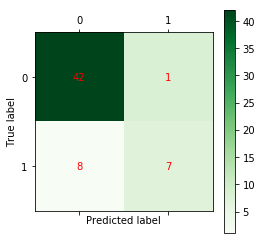

In [91]:
# 构建CART决策树模型
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier #导入决策树模型
tree=DecisionTreeClassifier()# 建立决策树模型
tree.fit(train[:,:3],train[:,3])  # 用训练数据拟合分类器模型
###  fit():用于从训练数据生成学习模型参数；函数返回值一般为调用fit方法的对象本身
###  fit(X,Y)为监督学习算法，fit(X,y=None)为无监督学习算法
###  fit_transform()作用：先拟合数据，然后转化它将其转化为标准形式
###  transform（）：通过找中心和缩放等实现标准化

# 保存模型
from sklearn.externals import joblib
joblib.dump(tree,r'D:\Entertainment\jyputer\Jyputer\Electric leakage\tree.pkl',compress=3) # 用于模型持久化的操作语句,compress可以将模型压缩成一个文件

# 利用测试集评价模型来计算混淆矩阵和ROC评价
from sklearn.metrics import confusion_matrix # 导入混淆矩阵函数
cm=confusion_matrix(test[:,3],tree.predict(test[:,:3]))  # 利用测试数据集制作混淆矩阵
#  confusion_matrix(y_true,y_pred,labels=None,sample_weight=None)
# y_true:样本真实分类结果；y_pred:样本预测结果
plt.matshow(cm,cmap=plt.cm.Greens) #画混淆矩阵图，配色风格使用cm.Greens
# matshow():把矩阵或数组绘制成图像的函数
plt.colorbar()#颜色标签

for x in range(len(cm)):#数据标签
    for y in range(len(cm)):
        plt.annotate(cm[x,y],xy=(x,y),color='r',horizontalalignment="center",verticalalignment='center')

plt.ylabel('True label') # 坐标轴标签
plt.xlabel('Predicted label') # 坐标轴标签
plt.show()#显示作图结果

#### 5.3  绘制ROC模型

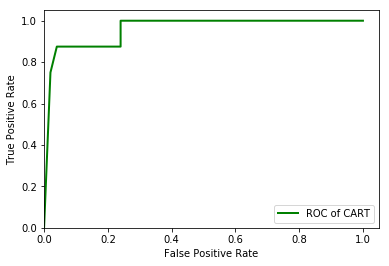

In [94]:
from sklearn.metrics import roc_curve  # 导入ROC曲线函数
fpr, tpr, thresholds = roc_curve(test[:,3], tree.predict_proba(test[:,:3])[:,1], pos_label=1)
plt.plot(fpr, tpr, linewidth=2, label = 'ROC of CART', color = 'green') #作出ROC曲线
plt.xlabel('False Positive Rate') #横坐标轴标签
plt.ylabel('True Positive Rate') #总坐标轴标签
plt.ylim(0,1.05) #边界范围
plt.xlim(0,1.05) #边界范围
plt.legend(loc=4) #图例
plt.show() #显示作图结果

sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)；

返回：

fpr:增加假阳性率，例如，i是预测的假阳性率，得分>=临界

tpr:增加真阳性率，例如，i是预测的真阳性率，得分>=临界值

### matplotlib图像可视化

##### 1、指向性注释annotate（）：在图中带有指向型文本注释信息，突显细节

matplotlib.pyplot.annotate(s,xy,xytext,weight,color,arrowprops)

s:str, 注释信息内容；xy:(float,float), 细节所在的坐标位置；xytext:(float,float), 注释内容的坐标位置；weight: str or int, 设置字体线型；color: str or tuple, 设置字体颜色 ；arrowprops：dict，设置指向箭头的参数；bbox：dict，为注释文本添加边框

##### 2、无指向型的注释文本 matplotlib.pyplot.text()函数，即只会在图中添加注释内容而无指向箭头

plt.text(x,y,s,family,fontsize,style,color)

x,y代表注释内容位置，s代表注释文本内容，family设置字体，自带的可选项有{'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}，fontsize字体大小，style设置字体样式，可选项{'normal', 'italic'(斜体), 'oblique'(也是斜体)}

#### 5.2  LM神经网络

### 小插播1： Python缺失值处理

In [9]:
# 查看缺失值
data.isnull()#查看所有缺失值

,日期,用户1,用户2,用户3
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,True,False
4,False,False,False,True
5,False,True,False,False
6,False,False,False,False
7,False,False,False,True
8,False,False,False,False
9,False,False,False,False


In [10]:
data.isnull().any()#获取含有缺失值的列

日期     False
用户1     True
用户2     True
用户3     True
dtype: bool

In [11]:
data.isnull().all()# 获取全部为NA的列

日期     False
用户1    False
用户2    False
用户3    False
dtype: bool

In [16]:
data.fillna(0)   # 缺失值用0替换

,日期,用户1,用户2,用户3
0,2014-09-01,235.8333,324.0343,478.3231
1,2014-09-02,236.2708,325.6379,515.4564
2,2014-09-03,238.0521,328.0897,517.0909
3,2014-09-04,235.9063,0.0000,514.8900
4,2014-09-05,236.7604,268.8324,0.0000
5,2014-09-06,0.0000,404.0480,486.0912
6,2014-09-07,237.4167,391.2652,516.2330
7,2014-09-08,238.6563,380.8241,0.0000
8,2014-09-09,237.6042,388.0230,435.3508
9,2014-09-10,238.0313,206.4349,487.6750


In [17]:
data.fillna(method='pad')#用前面的值替换

,日期,用户1,用户2,用户3
0,2014-09-01,235.8333,324.0343,478.3231
1,2014-09-02,236.2708,325.6379,515.4564
2,2014-09-03,238.0521,328.0897,517.0909
3,2014-09-04,235.9063,328.0897,514.8900
4,2014-09-05,236.7604,268.8324,514.8900
5,2014-09-06,236.7604,404.0480,486.0912
6,2014-09-07,237.4167,391.2652,516.2330
7,2014-09-08,238.6563,380.8241,516.2330
8,2014-09-09,237.6042,388.0230,435.3508
9,2014-09-10,238.0313,206.4349,487.6750


In [18]:
data.fillna(method='backfill')#用后面的值替换

,日期,用户1,用户2,用户3
0,2014-09-01,235.8333,324.0343,478.3231
1,2014-09-02,236.2708,325.6379,515.4564
2,2014-09-03,238.0521,328.0897,517.0909
3,2014-09-04,235.9063,268.8324,514.8900
4,2014-09-05,236.7604,268.8324,486.0912
5,2014-09-06,237.4167,404.0480,486.0912
6,2014-09-07,237.4167,391.2652,516.2330
7,2014-09-08,238.6563,380.8241,435.3508
8,2014-09-09,237.6042,388.0230,435.3508
9,2014-09-10,238.0313,206.4349,487.6750


In [22]:
data.fillna(data.mean()) # 用平均值替换

,日期,用户1,用户2,用户3
0,2014-09-01,235.833300,324.034300,478.323100
1,2014-09-02,236.270800,325.637900,515.456400
2,2014-09-03,238.052100,328.089700,517.090900
3,2014-09-04,235.906300,363.666265,514.890000
4,2014-09-05,236.760400,268.832400,553.901624
5,2014-09-06,236.262626,404.048000,486.091200
6,2014-09-07,237.416700,391.265200,516.233000
7,2014-09-08,238.656300,380.824100,553.901624
8,2014-09-09,237.604200,388.023000,435.350800
9,2014-09-10,238.031300,206.434900,487.675000


### 小插播2：在Python&numpy中切片(slice)

对于一维数组来说，Python原生的list和numpy的array(数组)的切片操作都是相同的。

list_name[start:end:step]

arr_name[行操作，列操作]--->arr_name[行起始：行终止，列起始：列终止：步长]

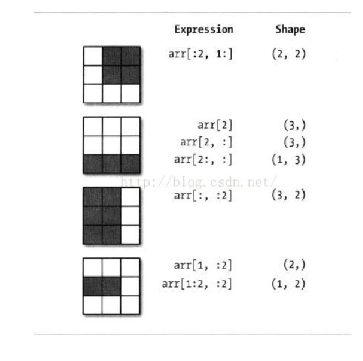

In [11]:
import matplotlib.image as mping
import matplotlib.pyplot as plt 

exp=mping.imread(r'D:\Entertainment\jyputer\Jyputer\Electric leakage\slice.png')
plt.figure(figsize=(6,6))
plt.imshow(exp)
plt.axis('off')
plt.show()

In [44]:
import numpy as np
arr=np.arange(9).reshape(3,3)
arr

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [8]:
arr[:2,1:]

array([[1, 2],
       [4, 5]])

In [14]:
a=arr[2]
b=arr[2,:]
c=arr[2:,:]
a,b,c

(array([6, 7, 8]), array([6, 7, 8]), array([[6, 7, 8]]))

In [15]:
arr[:,:2]

array([[0, 1],
       [3, 4],
       [6, 7]])

In [18]:
d=arr[1,:2]
e=arr[1:2,:2]
d,e

(array([3, 4]), array([[3, 4]]))

### 小插播3：Python & dataframe常见操作：取行、列、切片、统计特征值

In [49]:
import pandas as pd
import numpy as np
from pandas import *
from numpy import *
data=DataFrame(np.arange(16).reshape(4,4),index=list('ABCD'),columns=list('wxyz'))
print(data)

    w   x   y   z
A   0   1   2   3
B   4   5   6   7
C   8   9  10  11
D  12  13  14  15


In [50]:
print(data[0:2])  # 取前两行数据

   w  x  y  z
A  0  1  2  3
B  4  5  6  7


In [51]:
print(len(data))  # 求出一共多少行
print(data.columns.size) # 求出一共多少列

4
4


In [53]:
print(data.columns)  # 列索引名称
print(data.index)  # 行索引名称

Index(['w', 'x', 'y', 'z'], dtype='object')
Index(['A', 'B', 'C', 'D'], dtype='object')


loc：通过行标签索引行数据 loc[n]：表示索引的是第n行；loc['d']:表示索引的第d行

iloc：通过行号获取行数据，不能是字符

ix：结合前两种的混合索引

In [65]:
print(data.iloc[1]) # 取第2行数据

w    4
x    5
y    6
z    7
Name: B, dtype: int32


In [58]:
print(data['x']) # 取列索引为x的一列数据
print(data.loc['A']) # 取行索引为A的一行数据

A     1
B     5
C     9
D    13
Name: x, dtype: int32
w    0
x    1
y    2
z    3
Name: A, dtype: int32


In [60]:
print(data.loc[:,['x','z']])  # 取所有行以及columns为x,z的列
print(data.loc[["A","B"],['x','z']]) #表示选取'A'和'B'这两行以及columns为x,z的列的并

    x   z
A   1   3
B   5   7
C   9  11
D  13  15
   x  z
A  1  3
B  5  7


In [61]:
print (data.iloc[1:3,1:3])              #数据切片操作，切连续的数据块
print (data.iloc[[0,2],[1,2]])              #即可以自由选取行位置，和列位置对应的数据，

   x   y
B  5   6
C  9  10
   x   y
A  1   2
C  9  10


In [62]:
print(data[data>2])#表示选取数据集中大于0的数据
print(data[data.x>5])#表示选取数据集中大于0的数据

      w     x     y   z
A   NaN   NaN   NaN   3
B   4.0   5.0   6.0   7
C   8.0   9.0  10.0  11
D  12.0  13.0  14.0  15
    w   x   y   z
C   8   9  10  11
D  12  13  14  15


In [63]:
print(data.mean()) #默认对每一列的数据求平均值；若加上参数a.mean(1)则对每一行求平均值；

w    6.0
x    7.0
y    8.0
z    9.0
dtype: float64


In [64]:
print (data['x'].value_counts())    #统计某一列x中各个值出现的次数：

13    1
5     1
9     1
1     1
Name: x, dtype: int64


### 小插播4：fit()、fit_transform()、transform()

1.fit():用于从训练数据生成学习模型参数；函数返回值一般为调用fit方法的对象本身。fit(X,Y)为监督学习算法，fit(X,y=None)为无监督学习算法

2.fit_transform()作用：先拟合数据，然后转化它将其转化为标准形式

3.transform（）：通过找中心和缩放等实现标准化

#### fit_transform()与transform（）含义

transform()和fit_transform()二者的功能都是对数据进行某种统一处理（比如标准化~N(0,1)，将数据缩放(映射)到某个固定区间，归一化，正则化等）

fit_transform(trainData)对部分数据先拟合fit，找到该part的整体指标，如均值、方差、最大值最小值等等（根据具体转换的目的），然后对该trainData进行转换transform，从而实现数据的标准化、归一化等等。

根据对之前部分trainData进行fit的整体指标，对剩余的数据（testData）使用同样的均值、方差、最大最小值等指标进行转换transform(testData)，从而保证train、test处理方式相同。所以，一般都是这么用：

#### NOTE

必须先用fit_transform(trainData)，之后再transform(testData)

如果直接transform(testData)，程序会报错

如果fit_transfrom(trainData)后，使用fit_transform(testData)而不transform(testData)，虽然也能归一化，但是两个结果不是在同一个“标准”下的，具有明显差异。(一定要避免这种情况)